In [1]:
import os
import warnings
from math import atan2, degrees

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from ultralytics import YOLO
import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier


In [2]:

# 1. Nose
# 2. Left Eye
# 3. Right Eye
# 4. Left Ear
# 5. Right Ear
# 6. Left Shoulder
# 7. Right Shoulder
# 8. Left Elbow
# 9. Right Elbow
# 10. Left Wrist
# 11. Right Wrist
# 12. Left Hip
# 13. Right Hip
# 14. Left Knee
# 15. Right Knee
# 16. Left Ankle
# 17. Right Ankle


In [7]:
model = YOLO("yolo11x-pose.pt")
skeleton = [
    (16, 14), (14, 12), (17, 15), (15, 13), (12, 13),
    (6, 12), (7, 13), (6, 7), (6, 8), (7, 9),
    (8, 10), (9, 11), (2, 3), (1, 2), (1, 3),
    (2, 4), (3, 5), (4, 6), (5, 7)
]
def extract_keypoints_from_frame(frame, model, confidence_threshold=0.5):
    """
    Извлекает ключевые точки позы из одного кадра.
    Возвращает массив формы (17, 2) или массив заполненный нулями, если поза не обнаружена.
    """
    results = model.predict(source=frame, save=False, verbose=False)
    
    if not results:
        return np.zeros((17, 2), dtype=np.float32)
    
    for result in results:
        if result.keypoints is not None:
            keypoints_np = result.keypoints.cpu().numpy()
            if hasattr(keypoints_np, 'xyn'):
                pose = keypoints_np.xyn
                # Проверка формы ключевых точек
                if pose.ndim == 3 and pose.shape[1:] == (17, 2):
                    pose = pose[0]  # Извлекаем первую позу, если их несколько
                elif pose.ndim == 2 and pose.shape == (17, 2):
                    pass  # Всё в порядке
                else:
                    print(f"Неправильная форма ключевых точек: {pose.shape}")
                    return np.zeros((17, 2), dtype=np.float32)
                
                # Возвращаем ключевые точки
                return pose
    return np.zeros((17, 2), dtype=np.float32)

In [5]:
def compute_distance(kp1, kp2):
    """Вычисляет Евклидово расстояние между двумя ключевыми точками."""
    return np.linalg.norm(kp1 - kp2)

def compute_angle(kp1, kp2, kp3):
    """Вычисляет угол в kp2, образованный kp1-kp2-kp3."""
    v1 = kp1 - kp2
    v2 = kp3 - kp2
    angle_rad = np.arctan2(v2[1], v2[0]) - np.arctan2(v1[1], v1[0])
    angle_deg = degrees(angle_rad)
    return angle_deg if angle_deg >= 0 else angle_deg + 360


import os
import cv2
import pandas as pd
from tqdm import tqdm

def process_exercise_videos(
    data_dir: str,
    model,
    skeleton: list[tuple[int, int]],
    frame_rate: int = 1
) -> pd.DataFrame:
    """
    Обрабатывает все видео в папках-классах внутри data_dir,
    извлекает ключевые точки, расстояния по скелету и углы,
    и возвращает результирующий DataFrame.
    
    Параметры:
        data_dir: путь к директории с подпапками упражнений.
        model: объект модели для extract_keypoints_from_frame(frame, model).
        skeleton: список кортежей (idx1, idx2) — соединения между ключевыми точками.
        frame_rate: число кадров в секунду, которые нужно брать (1 = каждый кадр/sec).
    
    Возвращает:
        pd.DataFrame, где каждая строка — данные по одному кадру.
    """
    exercise_classes = [
        d for d in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, d))
    ]

    data = []

    for exercise in tqdm(exercise_classes, desc="Обработка классов"):
        exercise_path = os.path.join(data_dir, exercise)
        video_files = [
            f for f in os.listdir(exercise_path)
            if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))
        ]

        for video_name in tqdm(video_files, desc=f"Обработка {exercise}", leave=False):
            video_path = os.path.join(exercise_path, video_name)
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Не удалось открыть видео: {video_path}")
                continue

            fps = cap.get(cv2.CAP_PROP_FPS) or 30
            frame_interval = int(fps / frame_rate)
            frame_count = 0

            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                if frame_count % frame_interval == 0:
                    keypoints = extract_keypoints_from_frame(frame, model)
                    if keypoints is not None:
                        row = {
                            'video': video_name,
                            'class': exercise,
                            'frame_number': frame_count
                        }
                        # добавляем координаты
                        for idx, (x, y) in enumerate(keypoints, start=1):
                            row[f'kp{idx}_x'] = x
                            row[f'kp{idx}_y'] = y

                        # расстояния по скелету
                        for kp1_idx, kp2_idx in skeleton:
                            kp1 = keypoints[kp1_idx - 1]
                            kp2 = keypoints[kp2_idx - 1]
                            row[f'distance_{kp1_idx}_{kp2_idx}'] = compute_distance(kp1, kp2)

                        # углы по тройкам точек
                        angle_triplets = [
                            (12, 14, 16),
                            (13, 15, 17),
                            (2, 4, 6),
                            (3, 5, 7)
                        ]
                        for kp1_idx, kp2_idx, kp3_idx in angle_triplets:
                            if kp3_idx <= len(keypoints):
                                kp1 = keypoints[kp1_idx - 1]
                                kp2 = keypoints[kp2_idx - 1]
                                kp3 = keypoints[kp3_idx - 1]
                                row[f'angle_{kp1_idx}_{kp2_idx}_{kp3_idx}'] = compute_angle(kp1, kp2, kp3)

                        data.append(row)

                frame_count += 1

            cap.release()

    return pd.DataFrame(data)


ERROR! Session/line number was not unique in database. History logging moved to new session 1854


In [12]:
# пример вызова:
train_df = process_exercise_videos(
    data_dir=r"C:\Users\jet\Desktop\видосы\norm_v\train",
    model=model,
    skeleton = skeleton,
    frame_rate=1
)
print(df.head())


аботка false:  23%|██████████████▉                                                 | 28/120 [00:46<01:57,  1.28s/it]

Неправильная форма ключевых точек: (1, 0, 2)



аботка false:  57%|████████████████████████████████████▊                           | 69/120 [02:02<01:04,  1.26s/it]

Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something:   1%|▊                                                  | 6/401 [00:51<50:36,  7.69s/it]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something:   5%|██▎                                               | 19/401 [01:19<03:42,  1.72it/s]

Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something:  10%|█████                                             | 41/401 [01:21<00:35, 10.08it/s]


Неправильная форма ключевых точек: (1, 0, 2)


аботка man_doing_something:  13%|██████▌                                           | 53/401 [01:23<00:33, 10.45it/s]

Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something:  20%|██████████▏                                       | 82/401 [01:24<00:14, 21.46it/s]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something:  22%|██████████▉                                       | 88/401 [01:24<00:14, 21.01it/s]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something:  24%|████████████                                      | 97/401 [01:25<00:31,  9.61it/s]

Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something:  35%|████████████████▉                                | 139/401 [01:32<00:56,  4.62it/s]

Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something:  41%|███████████████████▉                             | 163/401 [01:36<00:31,  7.50it/s]

Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something:  47%|██████████████████████▉                          | 188/401 [01:40<00:22,  9.36it/s]


Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)


аботка man_doing_something:  47%|███████████████████████                          | 189/401 [01:40<00:27,  7.73it/s]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something:  82%|████████████████████████████████████████▎        | 330/401 [01:57<00:05, 13.35it/s]


Неправильная форма ключевых точек: (1, 0, 2)


аботка man_doing_something:  84%|█████████████████████████████████████████        | 336/401 [01:58<00:07,  8.75it/s]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something:  86%|██████████████████████████████████████████       | 344/401 [01:59<00:04, 11.57it/s]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something:  96%|███████████████████████████████████████████████  | 385/401 [02:03<00:01,  9.86it/s]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something:  97%|███████████████████████████████████████████████▌ | 389/401 [02:04<00:02,  5.49it/s]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something:  97%|███████████████████████████████████████████████▋ | 390/401 [02:28<00:53,  4.84s/it]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильн


аботка man_doing_something:  98%|███████████████████████████████████████████████▊ | 391/401 [03:53<03:40, 22.08s/it]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something:  98%|███████████████████████████████████████████████▉ | 392/401 [03:53<02:33, 17.03s/it]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)


Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)


аботка man_doing_something:  98%|████████████████████████████████████████████████▏| 394/401 [06:51<04:56, 42.33s/it]

Неправильная форма ключевых точек: (1, 0, 2)



аботка man_doing_something: 100%|████████████████████████████████████████████████▊| 399/401 [10:03<01:10, 35.31s/it]

Неправильная форма ключевых точек: (1, 0, 2)



аботка true:  23%|██████████████▊                                                  | 39/171 [01:43<09:02,  4.11s/it]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)



аботка true:  32%|████████████████████▌                                            | 54/171 [02:39<02:32,  1.30s/it]

Неправильная форма ключевых точек: (1, 0, 2)



аботка true:  67%|███████████████████████████████████████████                     | 115/171 [04:18<02:33,  2.74s/it]

Неправильная форма ключевых точек: (1, 0, 2)



аботка true:  83%|█████████████████████████████████████████████████████▏          | 142/171 [05:38<01:08,  2.38s/it]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)



аботка true:  91%|██████████████████████████████████████████████████████████▍     | 156/171 [07:04<02:29,  9.99s/it]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)



Обработка классов: 100%|████████████████████████████████████████████████████████████████| 3/3 [22:51<00:00, 457.28s/it]

Empty DataFrame
Columns: []
Index: []


In [13]:
# пример вызова:
test_df = process_exercise_videos(
    data_dir=r"C:\Users\jet\Desktop\видосы\norm_v\val",
    model=model,
    skeleton = skeleton,
    frame_rate=1
)
print(df.head())


аботка man_doing_something:   0%|                                                             | 0/3 [00:00<?, ?it/s]

Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)
Неправильная форма ключевых точек: (1, 0, 2)



аботка true:  74%|████████████████████████████████████████████████▋                 | 14/19 [00:51<00:26,  5.27s/it]

Неправильная форма ключевых точек: (1, 0, 2)



Обработка классов: 100%|█████████████████████████████████████████████████████████████████| 3/3 [03:38<00:00, 72.69s/it]

Empty DataFrame
Columns: []
Index: []


In [14]:
test_df

,video,class,frame_number,kp1_x,kp1_y,kp2_x,kp2_y,kp3_x,kp3_y,kp4_x,...,distance_1_2,distance_1_3,distance_2_4,distance_3_5,distance_4_6,distance_5_7,angle_12_14_16,angle_13_15_17,angle_2_4_6,angle_3_5_7
0,false_0000.mp4,false,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.729927,0.461922,197.922394,219.518537,23.543196,38.637093
1,false_0000.mp4,false,30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.744592,0.473911,216.190377,218.636568,25.494630,42.460704
2,false_0000.mp4,false,60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.772085,0.488060,212.999285,149.543249,28.647985,49.215498
3,false_0000.mp4,false,90,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.770780,0.537315,293.084869,349.296800,32.012055,50.827734
4,false_0001.mp4,false,0,0.655487,0.336950,0.704975,0.307557,0.589705,0.298358,0.000000,...,0.057559,0.076267,0.769143,0.137412,0.807226,0.202178,323.957932,347.476609,10.119233,140.839908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,true_0018.mp4,true,2430,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.548918,...,0.000000,0.000000,0.950068,0.923913,0.047690,0.043452,148.141585,142.181944,54.466346,18.705866
900,true_0018.mp4,true,2460,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.551440,...,0.000000,0.000000,0.928366,0.905705,0.055382,0.056926,323.862637,323.782601,55.229313,17.112684
901,true_0018.mp4,true,2490,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.550225,...,0.000000,0.000000,0.925754,0.903806,0.053264,0.056764,322.796192,323.536256,55.553453,17.571584
902,true_0018.mp4,true,2520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.551699,...,0.000000,0.000000,0.931972,0.908474,0.055005,0.055848,323.590597,323.242299,54.599528,17.718460


In [15]:
label_encoder = LabelEncoder()
test_df['class_encoded'] = label_encoder.fit_transform(test_df['class'])
train_df['class_encoded'] = label_encoder.fit_transform(train_df['class'])

all_classes = label_encoder.classes_
 
X_train = train_df.drop(['video', 'class', 'class_encoded', 'frame_number'], axis=1)
y_train = train_df['class_encoded']
X_test = test_df.drop(['video', 'class', 'class_encoded', 'frame_number'], axis=1)
y_test = test_df['class_encoded']

Обучение модели: Logistic Regression
Обучение модели: Decision Tree
Обучение модели: Random Forest
Обучение модели: Support Vector Machine
Обучение модели: K-Nearest Neighbors
Обучение модели: Gradient Boosting
Обучение модели: XGBoost
Обучение модели: Neural Network

Результаты моделей:
                    Model  Accuracy  Precision    Recall  F1-Score
0     Logistic Regression  0.730088   0.709382  0.723639  0.715750
1           Decision Tree  0.519912   0.515062  0.571202  0.521161
2           Random Forest  0.688053   0.663861  0.709592  0.677613
3  Support Vector Machine  0.464602   0.342410  0.491110  0.347650
4     K-Nearest Neighbors  0.571903   0.529313  0.561303  0.531428
5       Gradient Boosting  0.692478   0.651880  0.662869  0.656052
6                 XGBoost  0.732301   0.703254  0.717507  0.707112
7          Neural Network  0.487832   0.704991  0.611662  0.543407


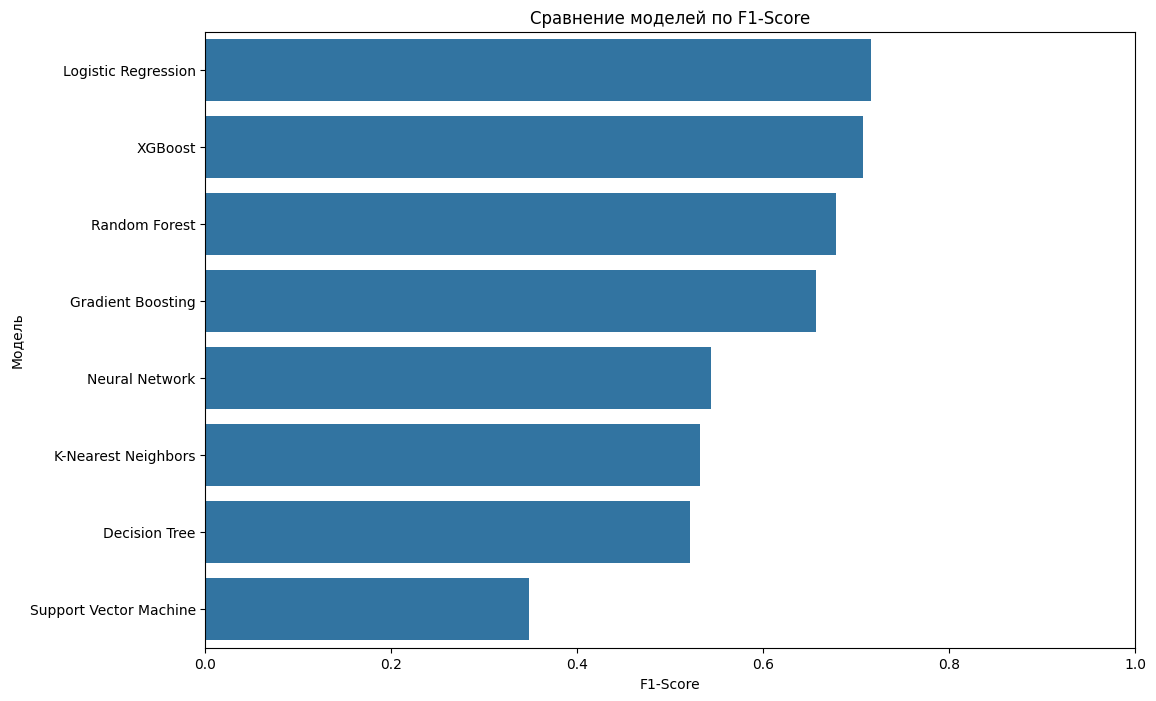

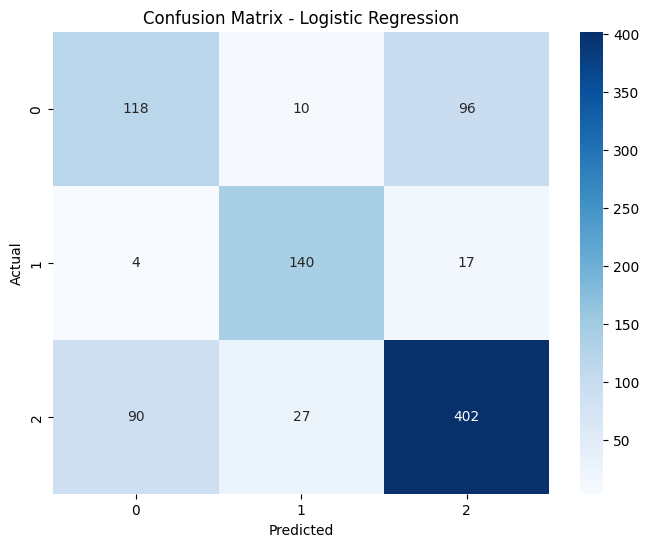

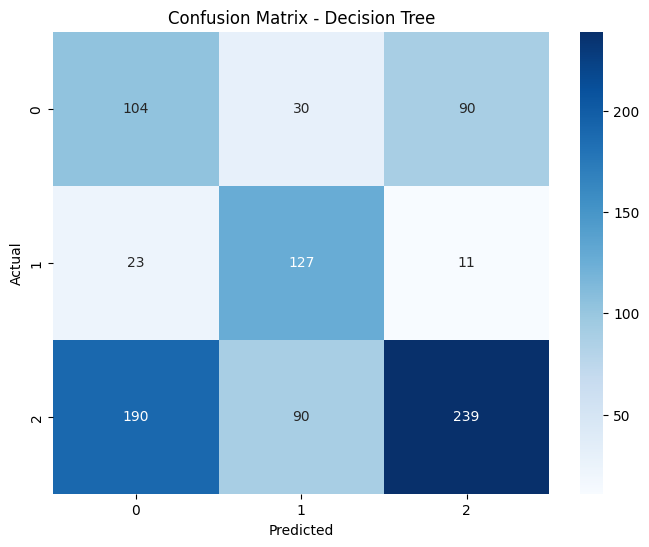

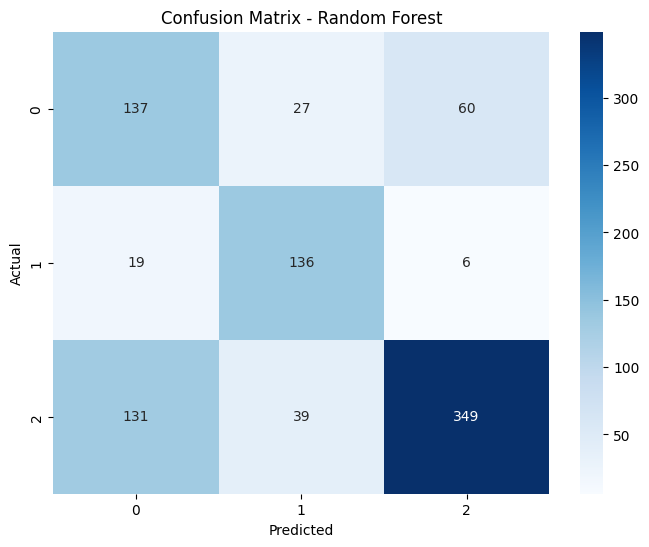

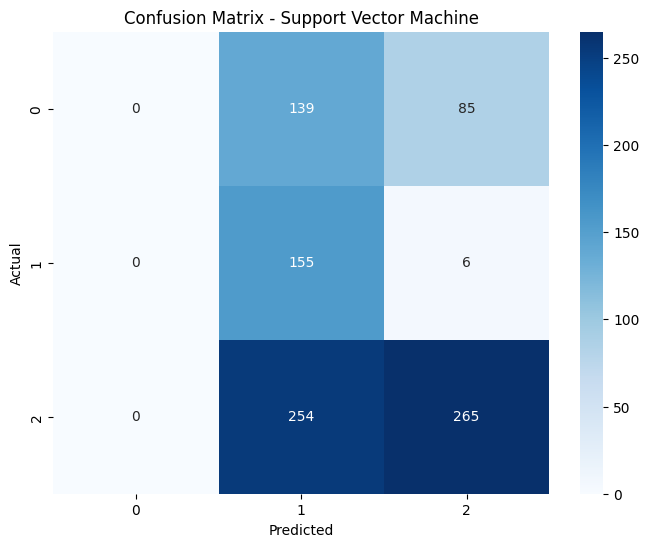

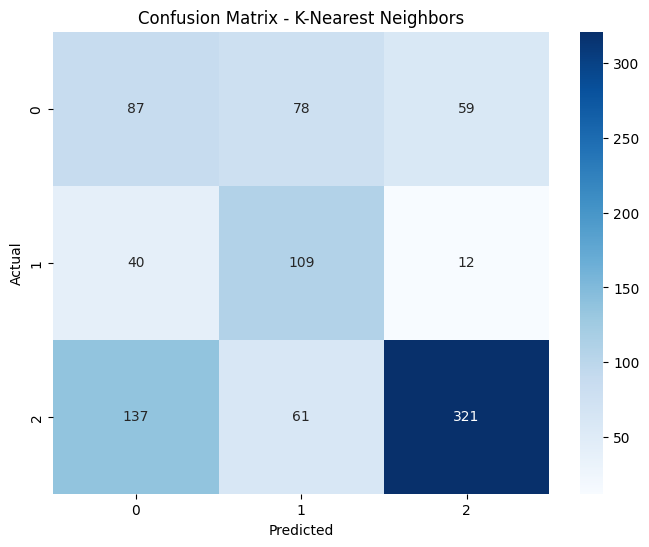

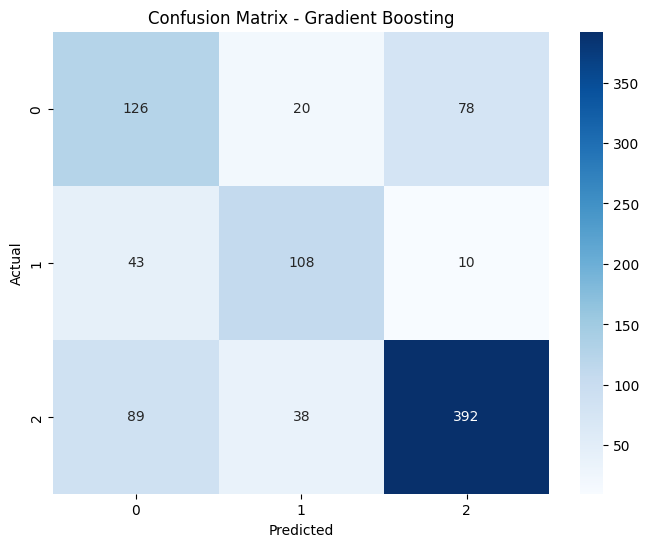

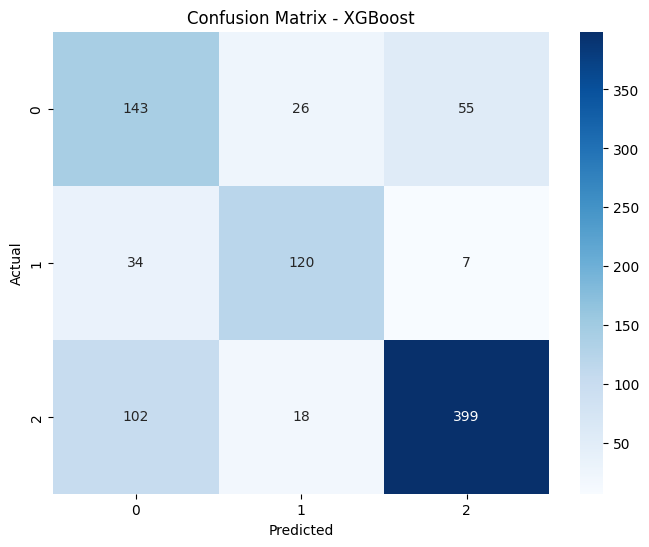

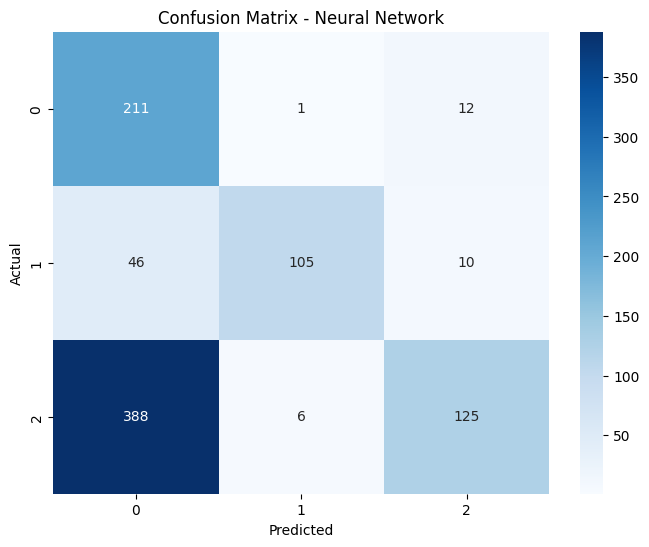

In [18]:

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    'Neural Network': MLPClassifier(max_iter=1000, random_state=42)
}


# Обучение моделей и сбор результатов
results = []

for name, model in models.items():
    print(f"Обучение модели: {name}")
    model.fit(X_train, y_train)  # Обучение модели на обучающей выборке
    
    # Предсказания для тестовых данных
    y_pred = model.predict(X_test)
    
    # Генерация отчёта
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Извлечение метрик
    accuracy = report['accuracy']
    precision = np.mean([
        v['precision'] for k, v in report.items() 
        if k not in ['accuracy', 'macro avg', 'weighted avg']
    ])
    recall = np.mean([
        v['recall'] for k, v in report.items() 
        if k not in ['accuracy', 'macro avg', 'weighted avg']
    ])
    f1 = np.mean([
        v['f1-score'] for k, v in report.items() 
        if k not in ['accuracy', 'macro avg', 'weighted avg']
    ])
    
    # Сохранение результатов
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Создание DataFrame с результатами
results_df = pd.DataFrame(results)
print("\nРезультаты моделей:")
print(results_df)


# Визуализация с помощью barplot
plt.figure(figsize=(12, 8))
sns.barplot(x='F1-Score', y='Model', data=results_df.sort_values('F1-Score', ascending=False))
plt.title('Сравнение моделей по F1-Score')
plt.xlabel('F1-Score')
plt.ylabel('Модель')
plt.xlim(0, 1)
plt.show()

# Дополнительно: Матрицы путаницы для каждой модели
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
